In [14]:
import numpy as np 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# different regressor test

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import NuSVR, SVR, LinearSVR 
from sklearn.linear_model import Lasso, Ridge, LinearRegression

import pandas as pd # process txt
from scipy.io import loadmat
from PIL import Image

from collections import defaultdict
from matplotlib.pyplot import imshow

In [2]:
folder = "G:/dataset/sun/"

standard_path = "G:/dataset/standard_split/SUN/"
proposed_path = "G:/dataset/proposed_split/SUN/"


cls_to_idx = {}
cnt = 0 
with open(standard_path + "allclasses.txt", "r", encoding='utf-8') as f: # TBD
     for row in f.readlines():
         row = row.rstrip()
         cls_to_idx[row] = cnt
         cnt = cnt + 1

sstrain, sstest = [], []
pstrain, pstest = [], []

# Standard Split 
with open(standard_path + "trainvalclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        sstrain.append(cls_to_idx[row])

with open(standard_path + "testclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        sstest.append(cls_to_idx[row])

print("standard_split:", len(sstrain), len(sstest))
# transform List(str) -> List(int)

# Proposed Split
with open(proposed_path + "trainvalclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        pstrain.append(cls_to_idx[row])

with open(proposed_path + "testclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        pstest.append(cls_to_idx[row])

print("proposed_split:", len(pstrain), len(pstest))

# Random Train & Test Class Split

train_class, test_class = [], [] 
X_class = list(range(717)) # label start from 0, you can adjust it
train_class, test_class = train_test_split(X_class, test_size=0.2)

# len(train_class), len(test_class) == (573, 144)

train_class, test_class = sstrain, sstest
train_class, test_class = pstrain, pstest



standard_split: 645 72
proposed_split: 645 72


In [3]:
print(*test_class, sep = ", ")

3, 622, 420, 482, 695, 298, 152, 679, 103, 509, 674, 95, 711, 645, 681, 517, 145, 85, 138, 631, 216, 425, 53, 558, 423, 72, 99, 130, 10, 440, 24, 336, 353, 658, 57, 245, 381, 286, 75, 124, 650, 196, 262, 342, 74, 254, 246, 448, 529, 656, 259, 221, 635, 112, 38, 580, 715, 237, 32, 23, 493, 328, 471, 712, 184, 358, 508, 379, 710, 315, 158, 560


In [13]:
class sunRead:
    def __init__(self, p, train_split):
        """
        p: 数据集存放路径
        train_split: 给出训练集
        """
        X_class = list(range(717))
        train_class = train_split
        test_class = list(filter(lambda i: i not in train_class, X_class))
        self.path = p
        # labels
        yp = self.path + "custom-sun-labels.txt"
        y = np.loadtxt(yp, delimiter=" ", encoding='utf-8')
        # visual features 2048 dimensions
        xp = self.path + "sun-features.txt"
        x = np.loadtxt(xp, delimiter=" ", encoding='utf-8')
        self.i1 = np.isin(y, train_class)
        self.i2 = np.isin(y, test_class)
        self.X_train, self.X_test = x[self.i1], x[self.i2]
        self.y_train, self.y_test = y[self.i1], y[self.i2]
    def index_train_test(self):
        return [self.i1, self.i2]
    def train_data(self):
        return self.X_train, self.y_train
    def test_data(self):
        return self.X_test, self.y_test
    def test(self): # 11788 all, add them to test
        print(self.X_train.shape, self.y_train.shape)
        print(self.X_test.shape, self.y_test.shape)

sunReader = sunRead(folder, train_class)
sunReader.test()
# custom
# standard 12900 + 1440

(12900, 2048) (12900,)
(1440, 2048) (1440,)


In [5]:
X_train, y_train = sunReader.train_data()
X_test, y_test = sunReader.test_data()
#X_train.shape, y_train.shape, X_test.shape, y_test.shape
pca_d = 500

exemPCA = decomposition.PCA(n_components=pca_d)
exemPCA.fit(X_train)
X_train = exemPCA.transform(X_train)
X_test = exemPCA.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12900, 500), (12900,), (1440, 500), (1440,))

In [6]:
# group up PCA projections

exem_train_group = defaultdict(list)

for c in train_class:
    exem_train_group[c] = []
        
for x, y in zip(X_train, y_train):
    exem_train_group[y].append(x)


# Average
exem_train = {}
std_train = {}
k = 0

for item in exem_train_group.items():
    y, ary = item
    exem_train[y] = np.mean(ary, axis=0) # Key Sentence
    std_train[y] = np.std(ary, axis=0)

del exem_train_group

# semantic embedding of SUN, 717 scenes, 102 attributes
# fork s.e. from essay "evaluation"
#se = folder + "sun_se_continuous.txt"

att = loadmat(standard_path + "att_splits.mat")
#semat = att['att'].T # transpose
semat = att['att_original']


# class to index, the same
a_c_train, a_c_test = semat[train_class], semat[test_class]
v_c_train = [exem_train[i] for i in train_class] # dict uses classes to index
sd_train = [std_train[i] for i in train_class]
sd_train = np.mean(sd_train, axis=0)

In [7]:
semat

array([[0.        , 0.08333333, 0.08333333, ..., 0.01666667, 0.05      ,
        0.01666667],
       [0.01666667, 0.78333333, 0.71666667, ..., 0.01666667, 0.06666667,
        0.01666667],
       [0.        , 0.06666667, 0.18333333, ..., 0.01666667, 0.08333333,
        0.08333333],
       ...,
       [0.        , 0.08333333, 0.08333333, ..., 0.01666667, 0.33333333,
        0.01666667],
       [0.        , 0.2       , 0.1       , ..., 0.03333333, 0.08333333,
        0.06666667],
       [0.05      , 0.        , 0.01666667, ..., 0.05      , 0.11666667,
        0.        ]])

In [8]:
np.array(a_c_train).shape, np.array(v_c_train).shape, np.array(sd_train).shape

((645, 102), (645, 500), (500,))

In [112]:
standard_path = "G:/dataset/standard_split/SUN/"

i_to_c = {}
idx = 0
with open(standard_path + "allclasses.txt", "r", encoding='utf-8') as f:
     for row in f.readlines():
         row = row.rstrip()
         i_to_c[idx] = row
         idx = idx + 1

imgs = np.loadtxt(folder + "sun-filenames.txt", dtype=str, encoding='utf-8')
train_index, test_index = sunReader.index_train_test()
     

In [111]:
# c = 2 ^ -3, nu = 2^0, gamma = 2 ^ -1
regress_group = []
k = 0
for j in range(pca_d):
    X = a_c_train # 
    y = [vc[j] for vc in v_c_train]
    regressor = Ridge()
    regressor.fit(X, y)
    regress_group.append(regressor)

v_c_test = np.zeros((72, pca_d)) # 提前定义好exemplar矩阵, 
# 对每一个维度进行预测
for j in range(pca_d):
    v_c_test[:, j] =  regress_group[j].predict(a_c_test) # 10 dimension , assign to column

v_c_test.shape, len(v_c_train), len(v_c_train[0])


exem_X, exem_y = [], []

for i, c in enumerate(test_class):
    exem_X.append(v_c_test[i])
    exem_y.append(c)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(exem_X, exem_y)
print("1NN:{} ".format(neigh.score(X_test, y_test)))

sneigh = KNeighborsClassifier(n_neighbors=1, metric='seuclidean', 
                    metric_params={'V':sd_train})
sneigh.fit(exem_X, exem_y)
print("1NNs:{}".format(sneigh.score(X_test, y_test)))


1NN:0.6034722222222222 
1NNs:0.6263888888888889


In [113]:
ary = sneigh.predict(X_test)
temp = ary == y_test

In [114]:
#temp

In [115]:
def predict(ix, paths):
    print("预测: ")
    l = sneigh.predict(X_test[[ix]])
    print("    " + i_to_c[l[0]])
    print("实际:")
    print("    " , paths[ix].split('/')[-3:-1])
    print("邻居[类别, 距离]:")
    neigh_dist, neigh_indices = sneigh.kneighbors(X_test[[ix]], n_neighbors=5)
    for d, i in zip(neigh_dist[0], neigh_indices[0]):
        ti = exem_y[i]
        print("   " + i_to_c[ti], d, sep=", ")
    im = Image.open(paths[ix])
    imshow(im)
    print(temp[ix])


预测: 
    artists_loft
实际:
     ['a', 'archive']
邻居[类别, 距离]:
   artists_loft, 24.647664449998196
   archive, 24.80022670451898
   doorway_indoor, 24.87111216127029
   bank_vault, 25.02766402403151
   elevator_interior, 25.255850217732444
False


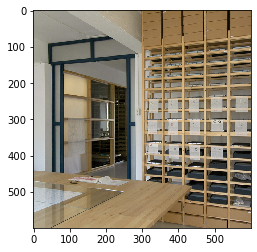

In [124]:
predict(56, imgs[test_index])

预测: 
    betting_shop
实际:
     ['b', 'betting_shop']
邻居[类别, 距离]:
   betting_shop, 23.794396581539115
   exhibition_hall, 23.909690698762578
   bazaar_indoor, 24.429830191966964
   firing_range_indoor, 24.67717188128638
   trading_floor, 24.681380738401845
True


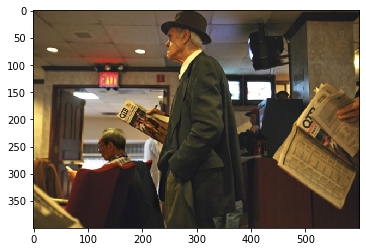

In [90]:
predict(233, imgs[test_index])

预测: 
    batting_cage_outdoor
实际:
     ['batting_cage', 'outdoor']
邻居[类别, 距离]:
   batting_cage_outdoor, 33.6455398869463
   racecourse, 34.82176659499057
   ticket_booth, 34.85311520979957
   dirt_track, 34.88226623762473
   bus_depot_outdoor, 34.96302054974396
True


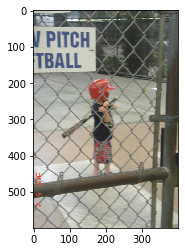

In [93]:
predict(177, imgs[test_index])

In [105]:
#regress_group[4].predict(a_c_test), regress_group[4].predict(a_c_test).shape, regress_group[5].predict(a_c_test)

In [11]:
## Save Exemplars and visual features of test class
#save_path = "./ridge_exem/"
#np.save(save_path + "exem_test.npy", np.array(exem_X))
#np.save(save_path + "X_test.npy", X_test)
#np.savetxt(save_path + "y_test.txt", np.array(y_test, dtype=int), fmt='%s', encoding='utf-8')

### GZSL

In [103]:
# c = 2 ^ -3, nu = 2^0, gamma = 2 ^ -1
regress_group = []
k = 0
for j in range(pca_d):
    X = a_c_train # 
    y = [vc[j] for vc in v_c_train]
    regressor = NuSVR()
    regressor.fit(X, y)
    regress_group.append(regressor)

v_c_test = np.zeros((72, pca_d)) # 提前定义好exemplar矩阵, 
# 对每一个维度进行预测
for j in range(pca_d):
    v_c_test[:, j] =  regress_group[j].predict(a_c_test) # 10 dimension , assign to column

v_c_test.shape, len(v_c_train), len(v_c_train[0])


exem_X, exem_y = [], []

for i, c in enumerate(test_class):
    exem_X.append(v_c_test[i])
    exem_y.append(c)

for i, c in enumerate(train_class):
    exem_X.append(v_c_train[i])
    exem_y.append(c)

    
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(exem_X, exem_y)
print("1NN:{} ".format(neigh.score(X_test, y_test)))

sneigh = KNeighborsClassifier(n_neighbors=1, metric='seuclidean', 
                    metric_params={'V':sd_train})
sneigh.fit(exem_X, exem_y)
print("1NNs:{}".format(sneigh.score(X_test, y_test)))


1NN:0.11944444444444445 
1NNs:0.14791666666666667


In [107]:
temp = sneigh == y_test

def predict(ix, paths):
    print("预测: ")
    l = sneigh.predict(X_test[[ix]])
    print("    " + i_to_c[l[0]])
    print("实际:")
    print("    " , paths[ix].split('/')[-3:-1])
    print("邻居[类别, 距离]:")
    neigh_dist, neigh_indices = sneigh.kneighbors(X_test[[ix]], n_neighbors=5)
    for d, i in zip(neigh_dist[0], neigh_indices[0]):
        ti = exem_y[i]
        print("   " + i_to_c[ti], d, sep=", ")
    im = Image.open(paths[ix])
    imshow(im)
    print(temp[ix])


预测: 
    kennel_indoor
实际:
     ['batting_cage', 'outdoor']
邻居[类别, 距离]:
   kennel_indoor, 29.899976627180372
   batting_cage_indoor, 32.73722132182902
   batting_cage_outdoor, 34.02792260119938
   jail_indoor, 34.48830006719192
   racecourse, 34.51066616270705
False


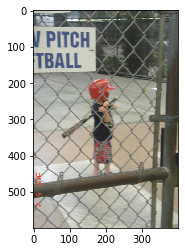

In [110]:
predict(177, imgs[test_index])

塞入全部的图片进行测试

```python
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(exem_X, exem_y)
print("1NN:{} ".format(neigh.score(np.concatenate([X_train, X_test], axis=0),np.concatenate([y_train, y_test], axis=0))))
```

In [12]:
# accuracy = neigh.score(X_test, y_test) # deprecated
# accuracy
# 4.8
# ZSL 0.44513888888888886
# GZSL 0.15381944444444445

# 4.13 Standard Split
# ZSL 0.575
# GZSL 0.14166666666666666

# 4.14 Standard Split with better ResNet101 features
# ZSL 
# 0.6215277777777778 nu-SVR C=2
# 0.6013888888888889 SVR
# 0.5972222222222222 nu-SVR default
# 0.5736111111111111 LinearSVR
# 0.6305555555555555 Lasso
# 0.5854166666666667 Ridge

# 4.16 Proposed Split 
# 0.5854166666666667 Ridge
# 0.597 nu-svr default
# 0.6215277777777778 nu-svr C=2